In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans22
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing




import warnings
warnings.filterwarnings('ignore')

In [2]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', #RED
    2 : 'EDEMA',  #Green
    3 : 'ENHANCING' #Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
#VOLUME_SLICES = 100  
VOLUME_SLICES = 48
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_DEPTH = 48
IMG_CHANNELS = 3

In [3]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

In [4]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

Text(0.5, 1.0, 'Mask')

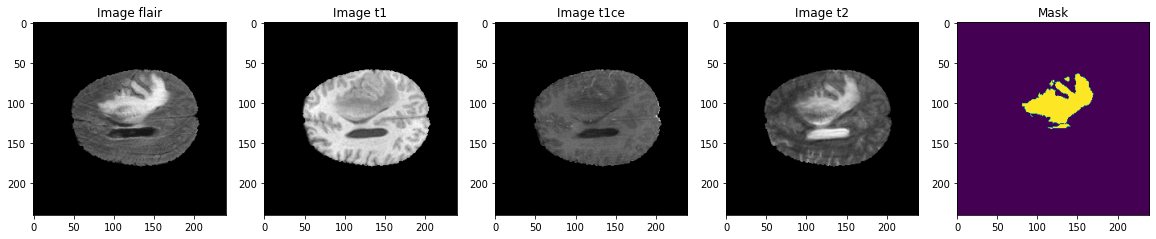

In [5]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

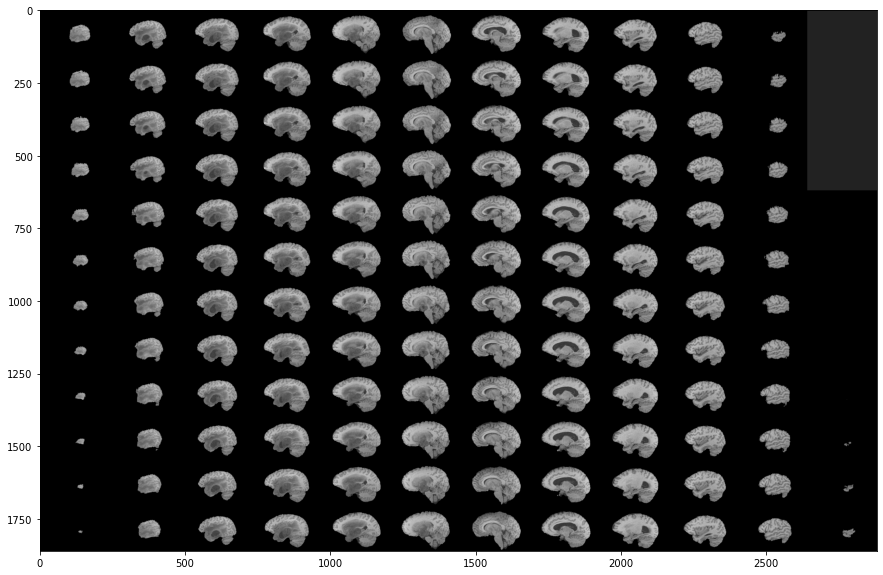

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

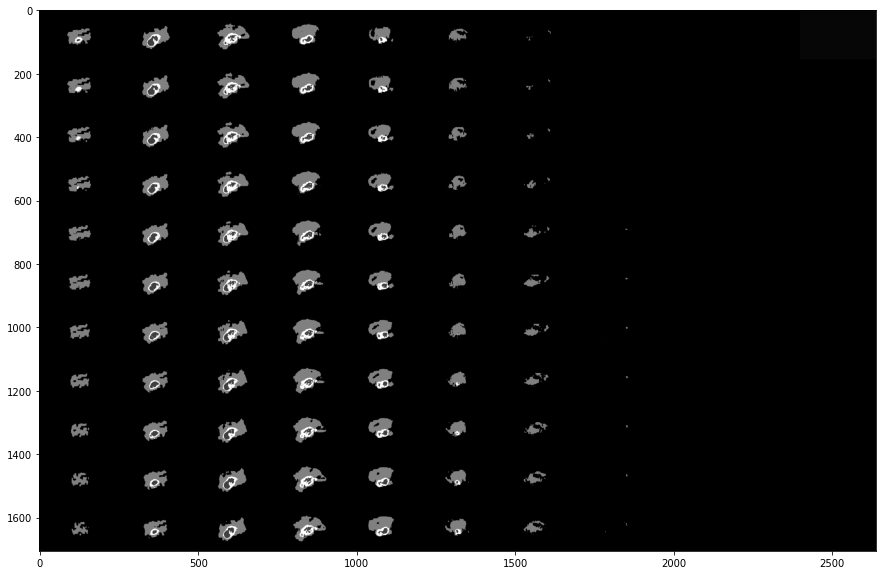

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

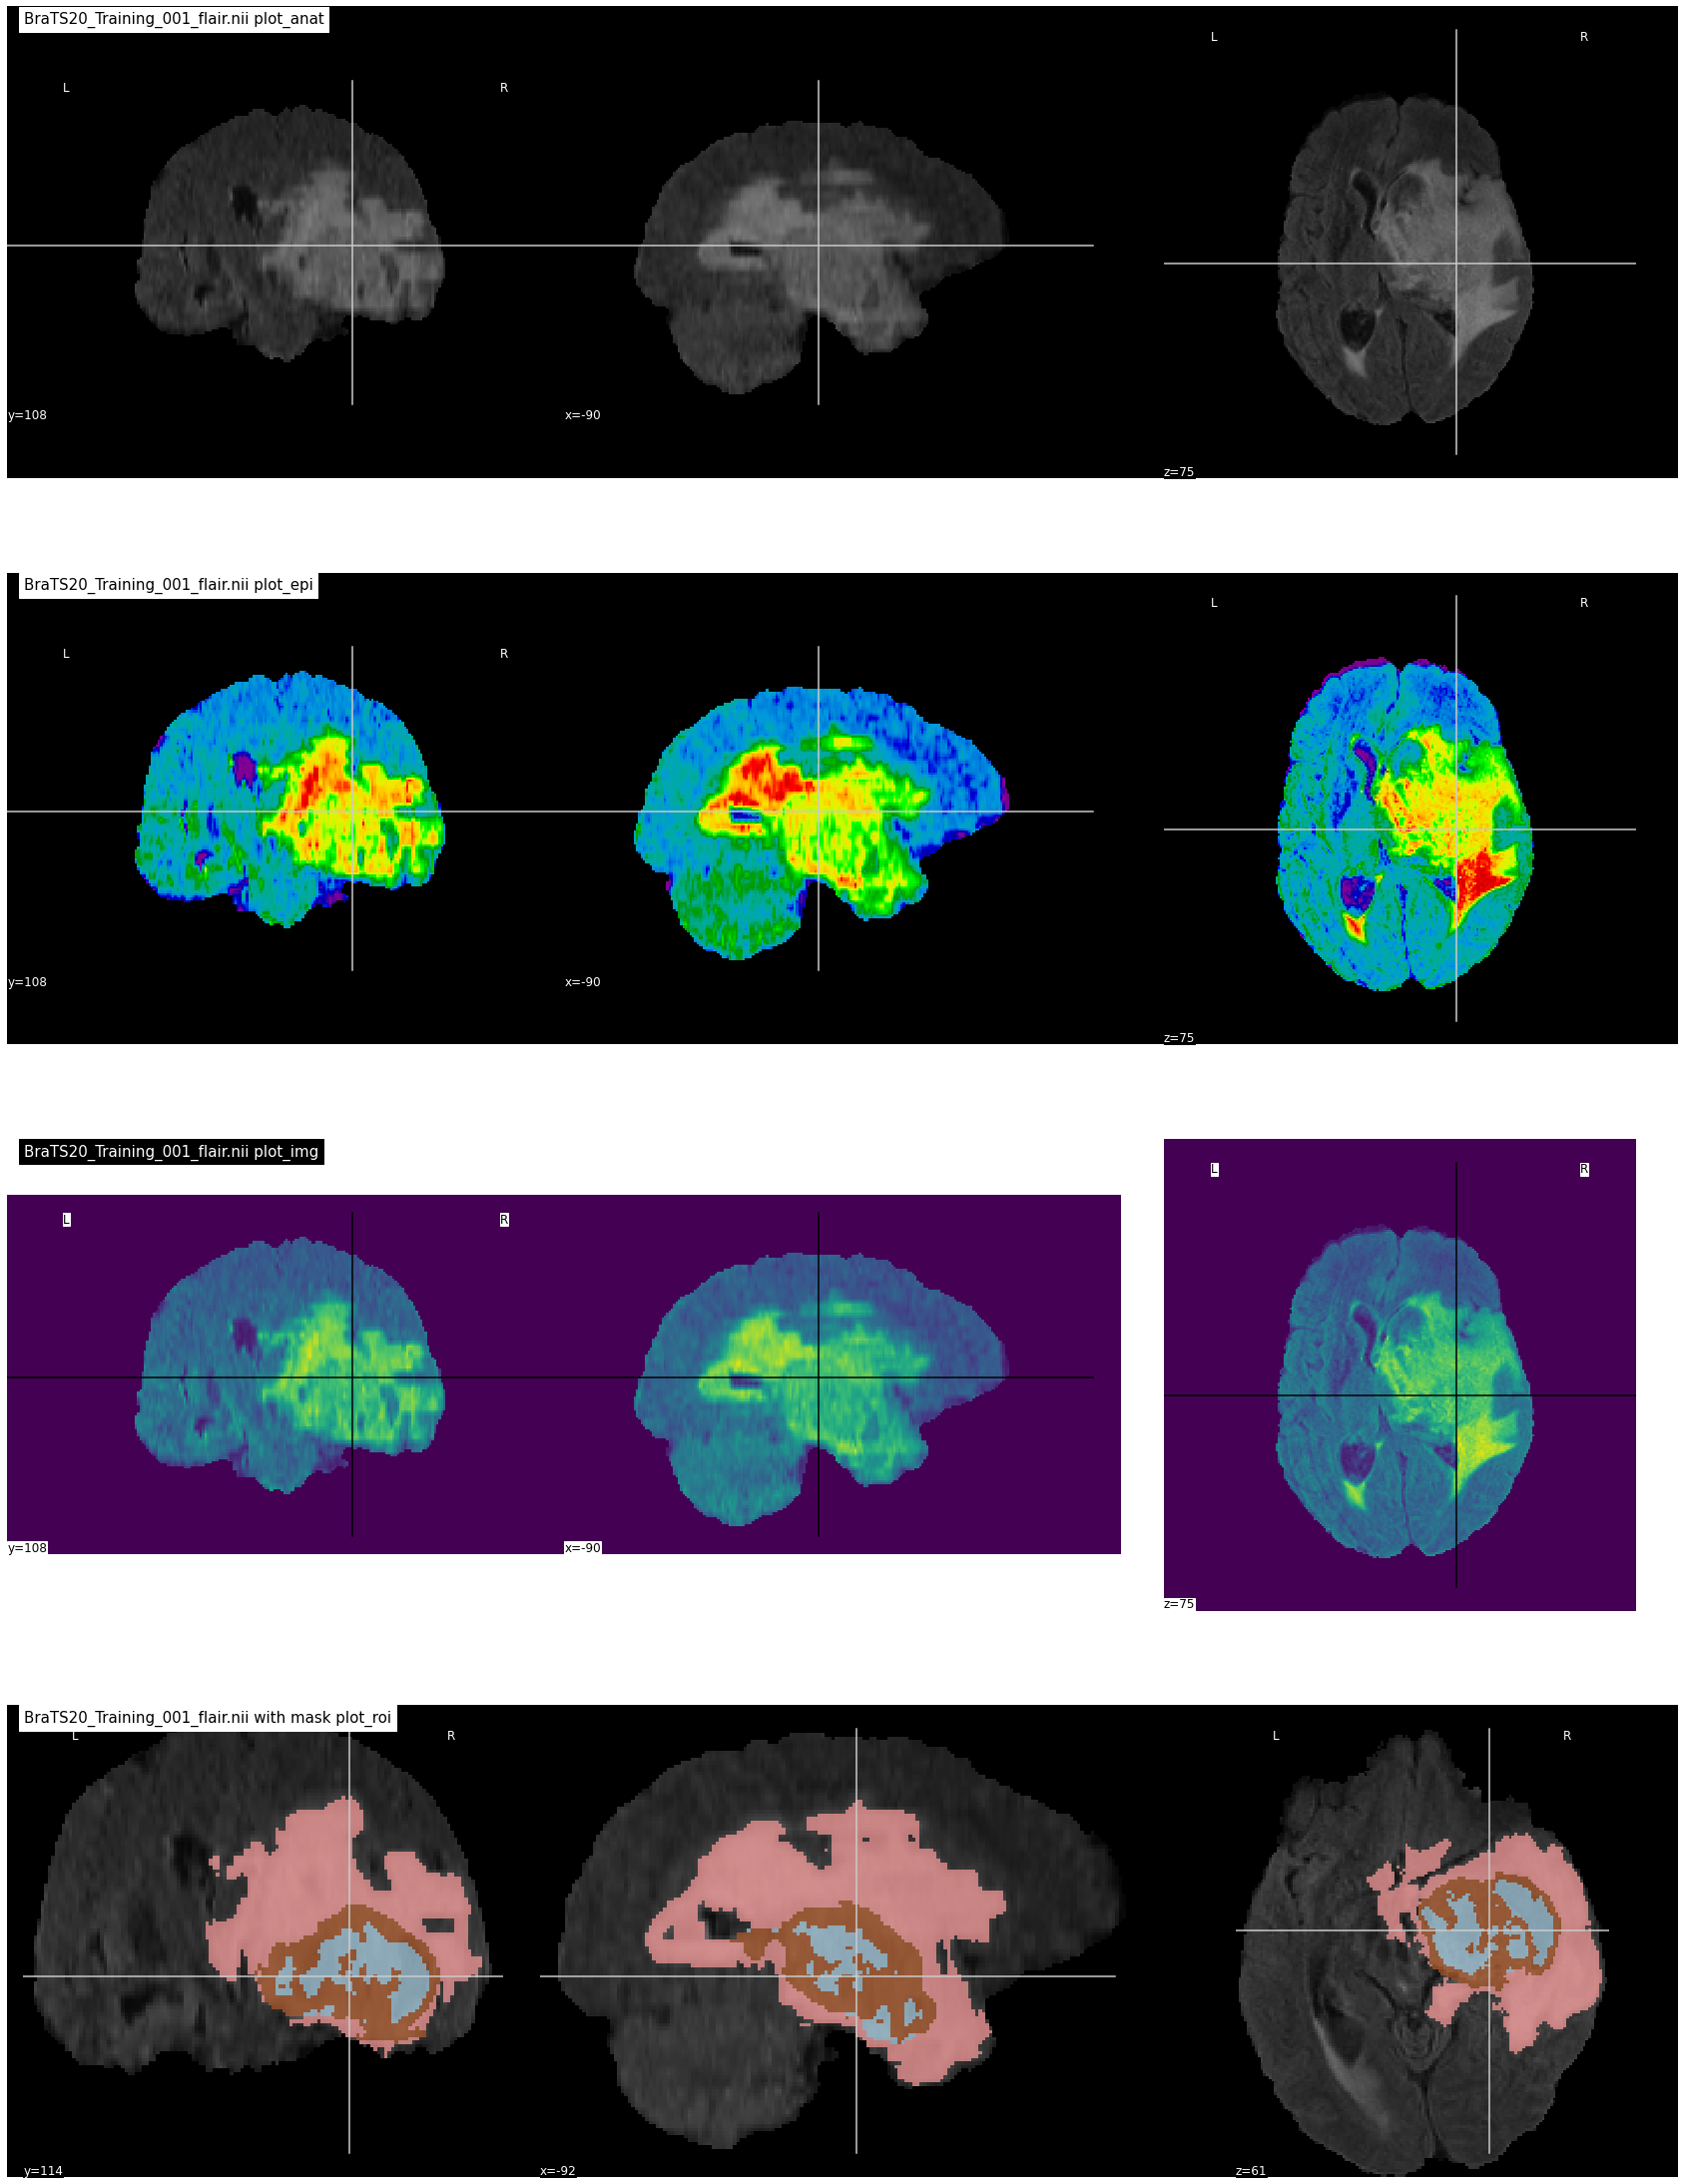

In [8]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))

#show anatomical details of the brain
nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])
#display high contrast image
nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])
#normal image
nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])
#overlapping the tumor segmentation mask on top of the MRI image
nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [9]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - dice

def jaccard_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return 1 - jaccard

def combined_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    jaccard = jaccard_loss(y_true, y_pred)
    return dice + jaccard


def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    prec = true_positives / (predicted_positives + K.epsilon())
    return prec

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sens = true_positives / (possible_positives + K.epsilon())
    return sens

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    spec = true_negatives / (possible_negatives + K.epsilon())
    return spec

def dice_coef_necrotic(y_true, y_pred):
    y_true_f = K.flatten(y_true[..., 0])  
    y_pred_f = K.flatten(y_pred[..., 0])
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
    return dice

def dice_coef_edema(y_true, y_pred):
    y_true_f = K.flatten(y_true[..., 1])  
    y_pred_f = K.flatten(y_pred[..., 1])
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
    return dice

def dice_coef_enhancing(y_true, y_pred):
    y_true_f = K.flatten(y_true[..., 2])  
    y_pred_f = K.flatten(y_pred[..., 2])
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
    return dice

In [10]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [11]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Define the output directory path
output_dir = '/kaggle/working/'

# Function to save IDs to a text file in the output directory
def save_ids_to_file(ids, file_name):
    file_path = os.path.join(output_dir, file_name)
    with open(file_path, 'w') as file:
        for id_ in ids:
            file.write(id_ + '\n')

# Print the number of images in each set
print("Number of images in training set:", len(train_ids))
print("Number of images in validation set:", len(val_ids))
print("Number of images in test set:", len(test_ids))


Number of images in training set: 249
Number of images in validation set: 74
Number of images in test set: 45


In [12]:
import cv2
import numpy as np

def ResizeAndReduceSlices(nib, size, slices, gap):
    imgs = np.zeros((128, 128, 48))

    # Loop over the slices and resize each one
    for i in range(slices):
        
        imgs[:,:,i] = cv2.resize(nib[:,:,int(i * gap + 20)], (size, size))

    return imgs


In [13]:
my_test_ids = ['BraTS20_Training_319',
               'BraTS20_Training_252', 
               'BraTS20_Training_195', 
               'BraTS20_Training_163', 
               'BraTS20_Training_213', 
               'BraTS20_Training_209', 
               'BraTS20_Training_337', 
               'BraTS20_Training_058',
               'BraTS20_Training_278',
               'BraTS20_Training_025', 
               'BraTS20_Training_143', 
               'BraTS20_Training_193', 
               'BraTS20_Training_008',
               'BraTS20_Training_024',
               'BraTS20_Training_219',
               'BraTS20_Training_266',
               'BraTS20_Training_282',
               'BraTS20_Training_097',
               'BraTS20_Training_217',
               'BraTS20_Training_153',
               'BraTS20_Training_299',
               'BraTS20_Training_035',
               'BraTS20_Training_349',
               'BraTS20_Training_129', 
               'BraTS20_Training_115',
               'BraTS20_Training_002', 
               'BraTS20_Training_311', 
               'BraTS20_Training_265', 
               'BraTS20_Training_231',
               'BraTS20_Training_020',
               'BraTS20_Training_031',
               'BraTS20_Training_036',
               'BraTS20_Training_131',
               'BraTS20_Training_204',
               'BraTS20_Training_347',
               'BraTS20_Training_155', 
               'BraTS20_Training_161',
               'BraTS20_Training_041', 
               'BraTS20_Training_107', 
               'BraTS20_Training_296', 
               'BraTS20_Training_047',
               'BraTS20_Training_238', 
               'BraTS20_Training_322', 
               'BraTS20_Training_016', 
               'BraTS20_Training_060']


In [14]:

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH), batch_size = 1, n_channels = 3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        X = np.zeros((self.batch_size, *self.dim, self.n_channels)) # shape of (5, 128, 128, 128, 3)
        Y = np.zeros((self.batch_size, *self.dim)) # shape of (5, 128, 128, 128)
        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata() 

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t2.nii'); 
            t2 = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

 
            slice_w = 25

            for j in range(VOLUME_SLICES):
                X[c,:,:,j,0] = cv2.resize(flair[:,:,VOLUME_START_AT+int(j*2.5)], (IMG_HEIGHT, IMG_WIDTH));
                X[c,:,:,j,1] = cv2.resize(ce[:,:,VOLUME_START_AT+int(j*2.5)], (IMG_HEIGHT, IMG_WIDTH));
                X[c,:,:,j,2] = cv2.resize(t2[:,:,VOLUME_START_AT+int(j*2.5)], (IMG_HEIGHT, IMG_WIDTH));

                #y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                Y[c,:,:,j] = cv2.resize(seg[:,:,VOLUME_START_AT+int(j*2.5)], (IMG_HEIGHT, IMG_WIDTH));

        Y[Y==4] = 3;
        mask = tf.one_hot(Y, 4);
       
        return X/np.max(X), mask
        #return temp_combined_images/np.max(temp_combined_images), temp_mask
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)
my_test_generator = DataGenerator(my_test_ids)

249
74
45
249
74
45
(128, 128, 48)


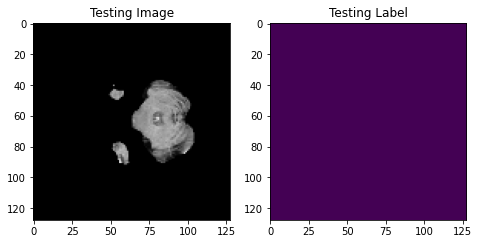

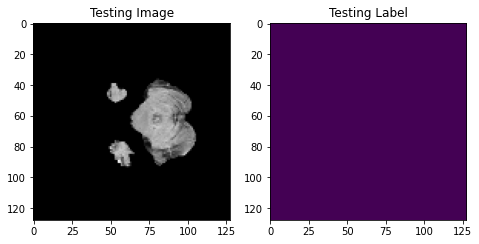

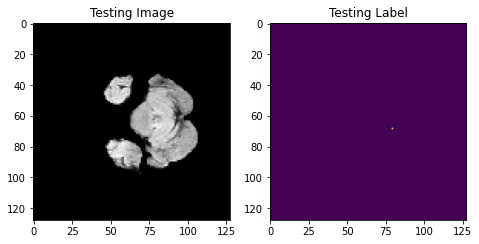

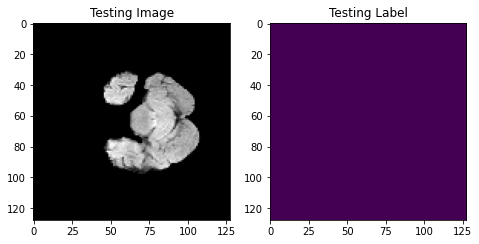

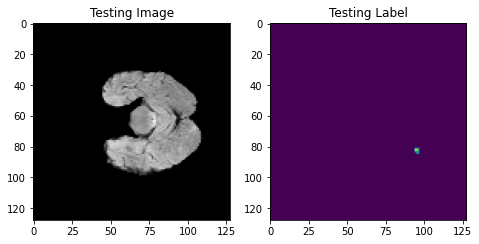

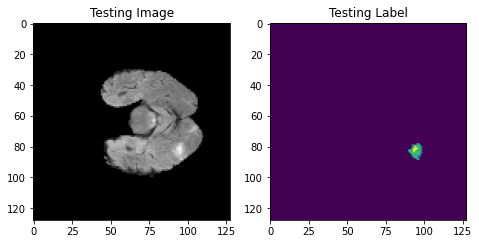

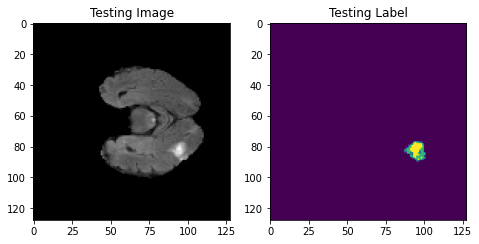

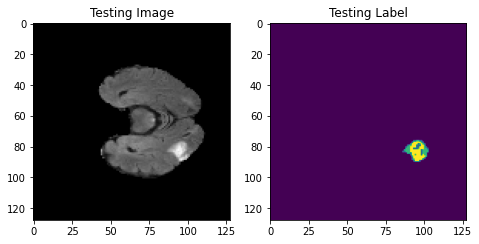

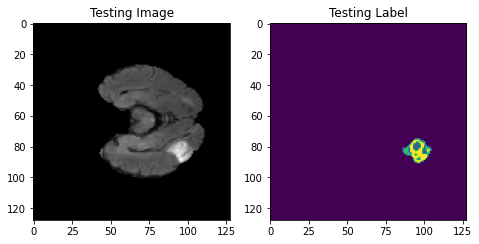

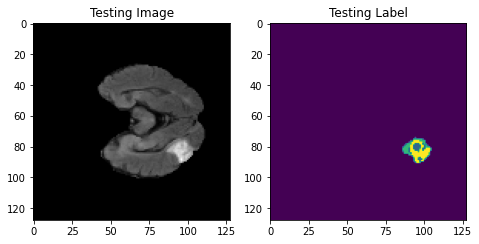

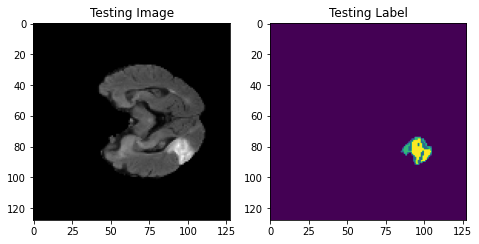

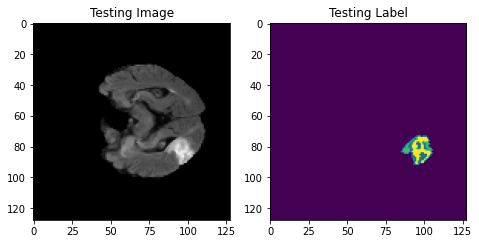

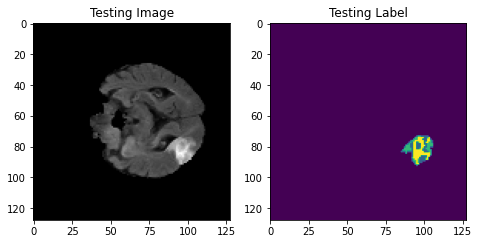

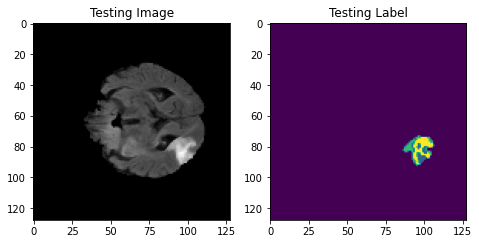

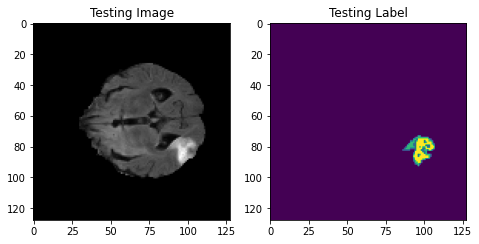

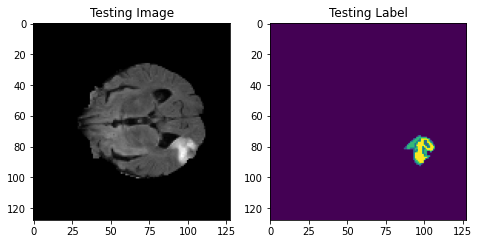

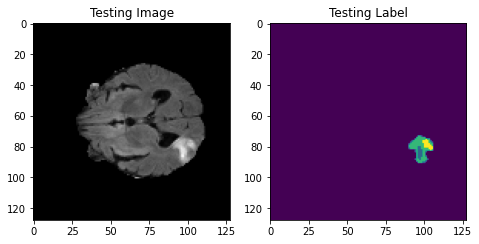

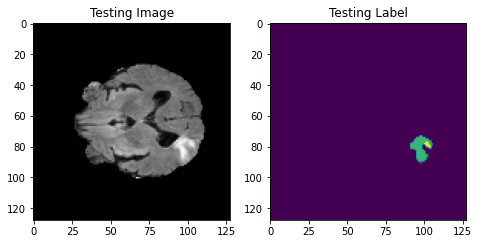

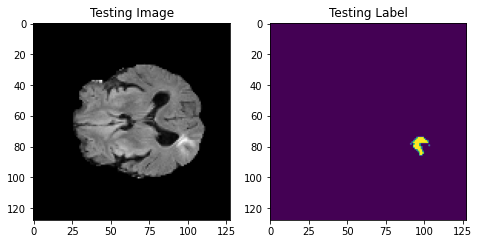

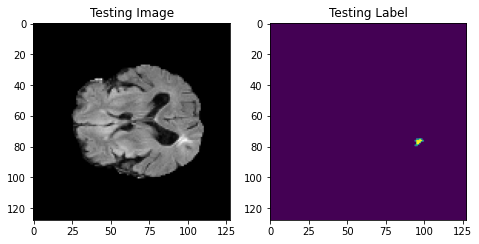

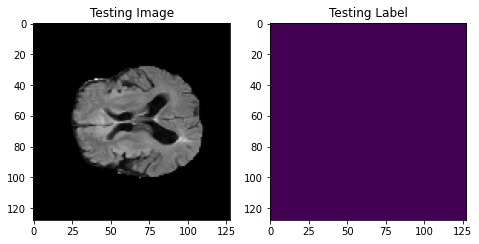

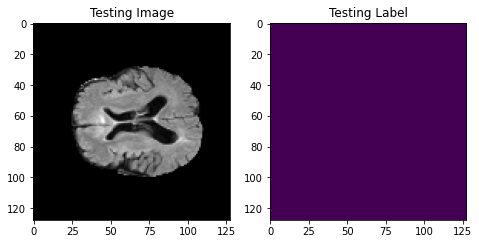

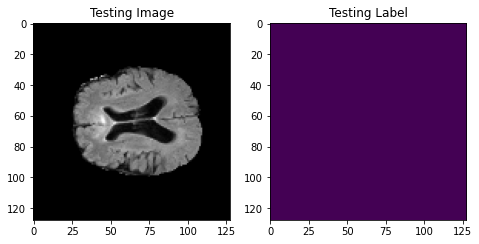

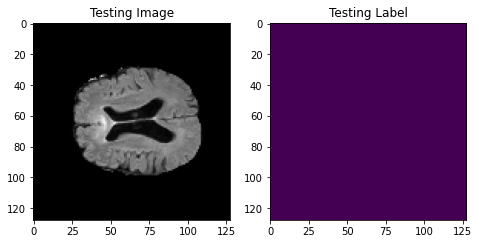

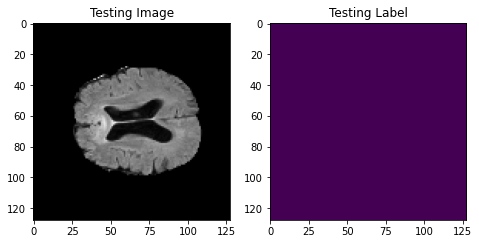

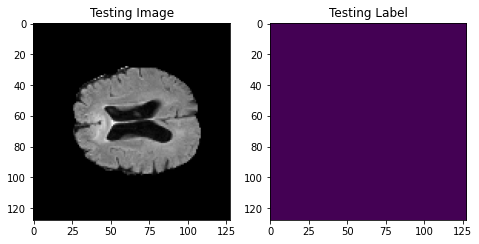

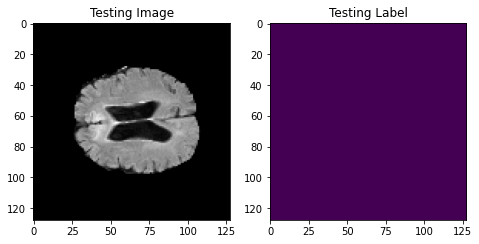

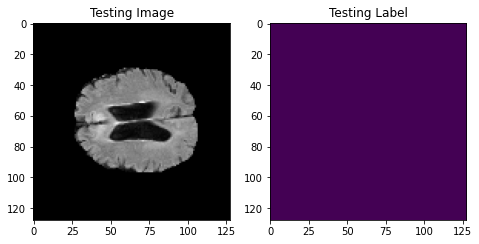

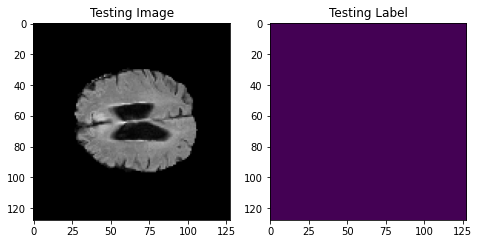

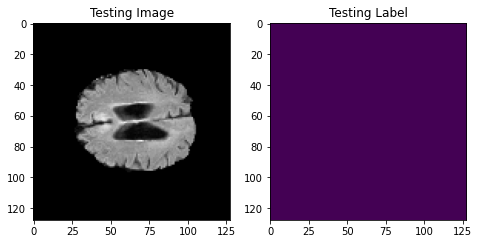

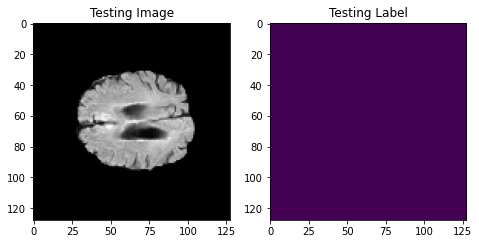

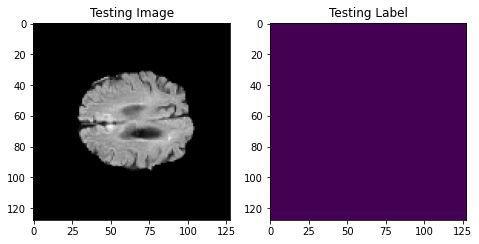

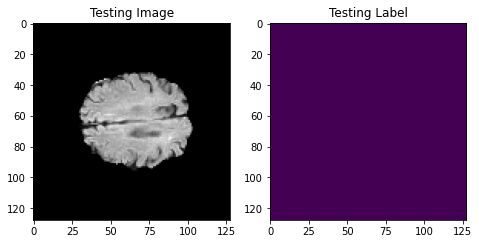

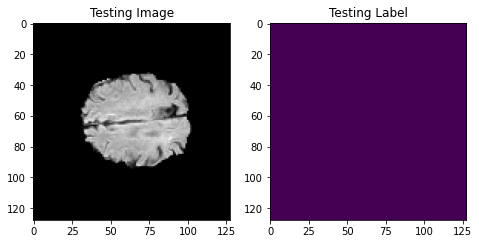

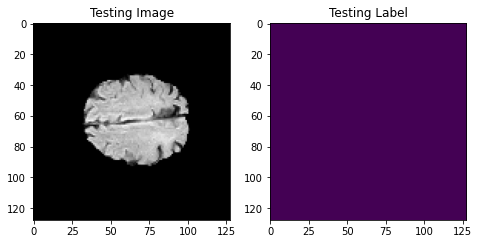

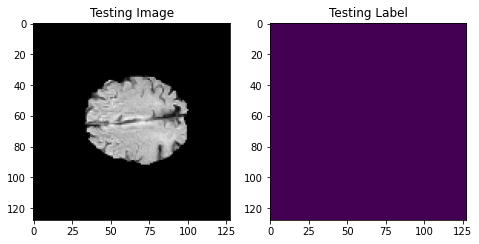

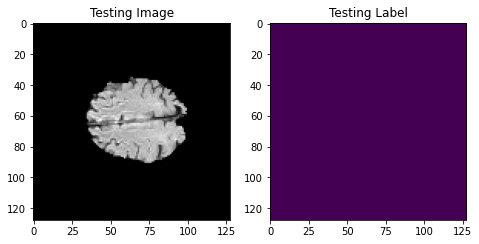

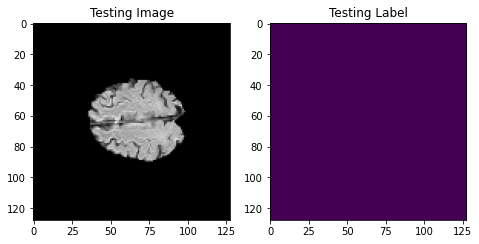

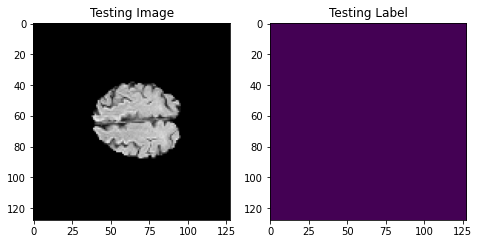

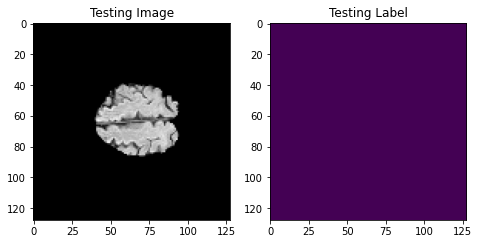

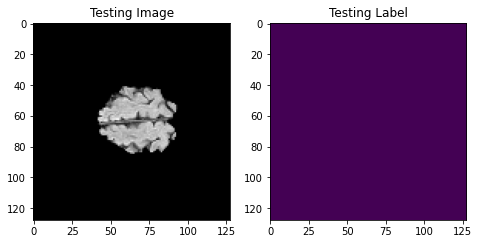

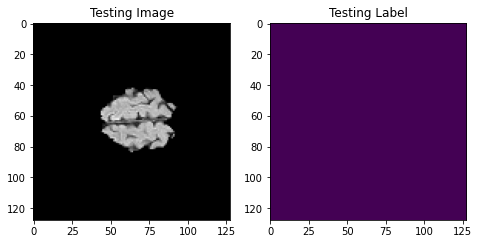

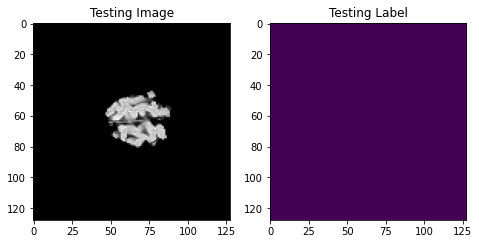

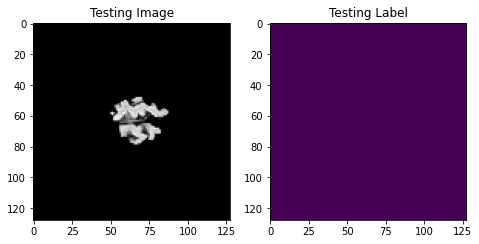

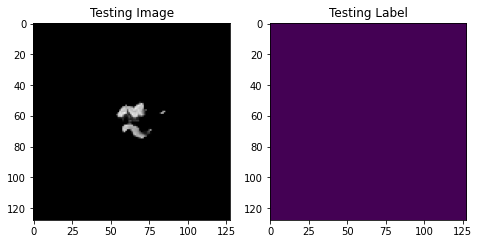

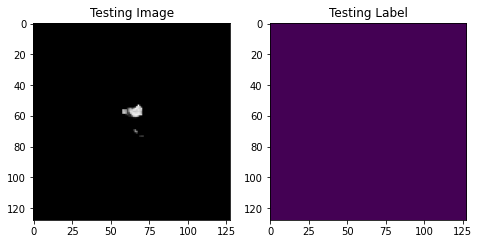

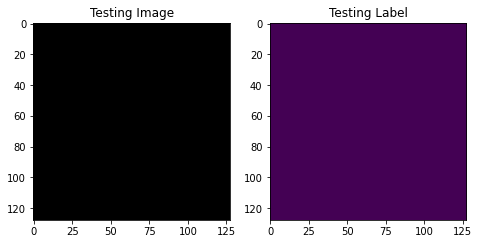

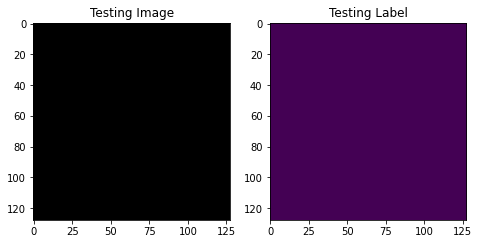

In [15]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))
print(len(training_generator))
print(len(valid_generator))
print(len(test_generator))
img, mask = test_generator[0]
mask=np.argmax(mask, axis=4)[0,:,:,:]
print(mask.shape)
for n_slice in range(48):
# n_slice = 24
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(img[0,:,:,n_slice,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(mask[:,:,n_slice])

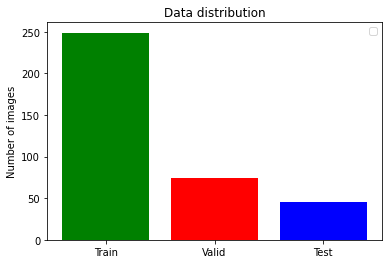

In [16]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.savefig('data2020.png')
    plt.show()
    
showDataLayout()

In [19]:
def build_unet(inputs, ker_init):
    num_classes = 4
    s = inputs  #(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS)

    #Encoder
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    #bottleneck
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c5)
    
    #Decoder 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c7)
         
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    
    return model

input_layer = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, 3))
model = build_unet(input_layer, 'he_normal')
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )
print(model.input_shape)
print(model.output_shape)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 48 0                                            
__________________________________________________________________________________________________
conv3d_19 (Conv3D)              (None, 128, 128, 48, 1312        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 48, 0           conv3d_19[0][0]                  
__________________________________________________________________________________________________
conv3d_20 (Conv3D)              (None, 128, 128, 48, 6928        dropout_9[0][0]                  
____________________________________________________________________________________________

In [20]:
history =  model.fit(training_generator,
                    epochs=50,
                    steps_per_epoch=len(train_ids),
                    validation_data = valid_generator
                    )

Epoch 1/50
249/249 [==============================] - 240s 922ms/step - loss: 0.1856 - accuracy: 0.9821 - mean_io_u: 0.5355 - dice_coef: 0.9212 - precision: 0.9741 - sensitivity: 0.9233 - specificity: 0.9953 - dice_coef_necrotic: 0.9505 - dice_coef_edema: 0.0252 - dice_coef_enhancing: 0.0471 - val_loss: 0.0653 - val_accuracy: 0.9841 - val_mean_io_u: 0.6722 - val_dice_coef: 0.9662 - val_precision: 0.9841 - val_sensitivity: 0.9841 - val_specificity: 0.9947 - val_dice_coef_necrotic: 0.9839 - val_dice_coef_edema: 0.0490 - val_dice_coef_enhancing: 0.0795
Epoch 2/50
249/249 [==============================] - 122s 491ms/step - loss: 0.0597 - accuracy: 0.9855 - mean_io_u: 0.6349 - dice_coef: 0.9742 - precision: 0.9869 - sensitivity: 0.9848 - specificity: 0.9956 - dice_coef_necrotic: 0.9878 - dice_coef_edema: 0.0468 - dice_coef_enhancing: 0.0724 - val_loss: 0.0661 - val_accuracy: 0.9842 - val_mean_io_u: 0.3752 - val_dice_coef: 0.9588 - val_precision: 0.9882 - val_sensitivity: 0.9833 - val_speci

In [36]:
model.save("model_base_unet3d.h5")

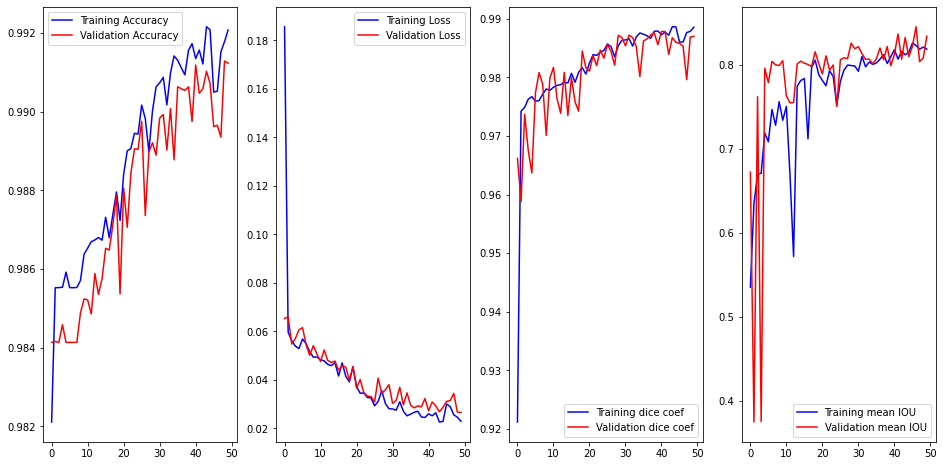

In [37]:
############ load trained model ################
model = tf.keras.models.load_model('/kaggle/working/model_base_unet3d.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing,
                                                   "jaccard_loss":jaccard_loss
                                                  }, compile=False)


############### ########## ####### #######

hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()
plt.savefig('training_result_2018.png')
plt.show()

In [38]:
model = tf.keras.models.load_model('/kaggle/working/model_base_unet3d.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(my_test_generator, batch_size=100)
print("test loss, test acc:", results)

Evaluate on test data
45/45 [==============================] - 9s 168ms/step - loss: 0.0215 - accuracy: 0.9928 - mean_io_u_8: 0.8320 - dice_coef: 0.9889 - precision: 0.9953 - sensitivity: 0.9907 - specificity: 0.9984 - dice_coef_necrotic: 0.9966 - dice_coef_edema: 0.3291 - dice_coef_enhancing: 0.4389
test loss, test acc: [0.021505678072571754, 0.9927526116371155, 0.8320316076278687, 0.9888675212860107, 0.9952685236930847, 0.9907475113868713, 0.9984311461448669, 0.9966260194778442, 0.32905280590057373, 0.4389497637748718]


test_prediction_shape: (1, 128, 128, 48, 4)
test_prediction_argmax_shape: (128, 128, 48)
[0 1 2 3]
test_img_shape: (1, 128, 128, 48, 3)
test_mask_shape: (1, 128, 128, 48, 4)
test_mask_argmax: (128, 128, 48)


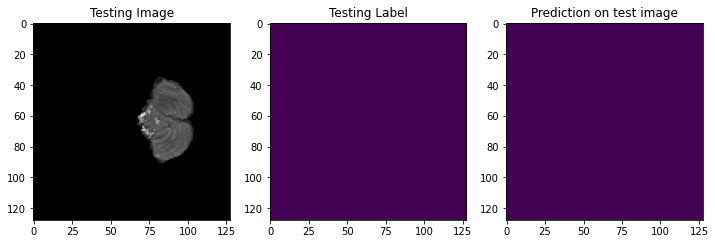

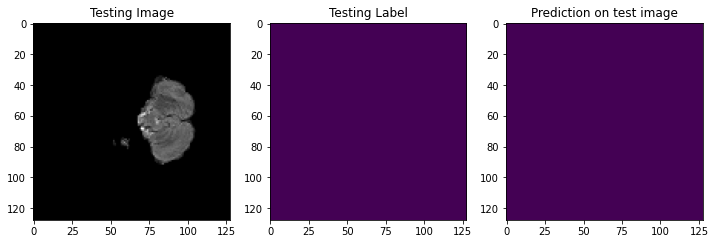

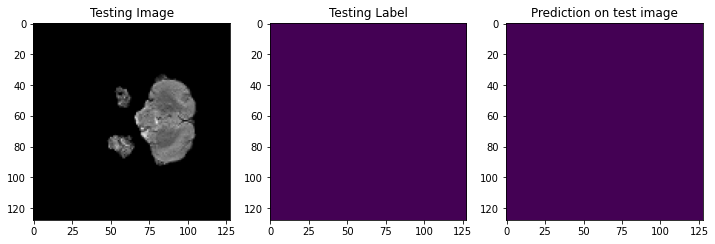

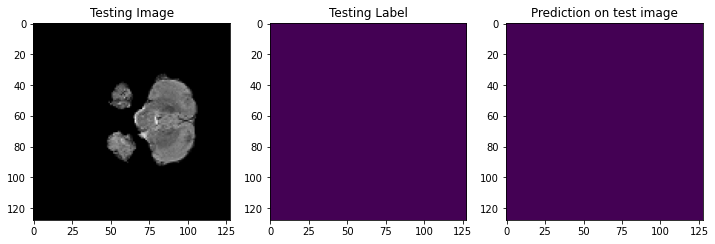

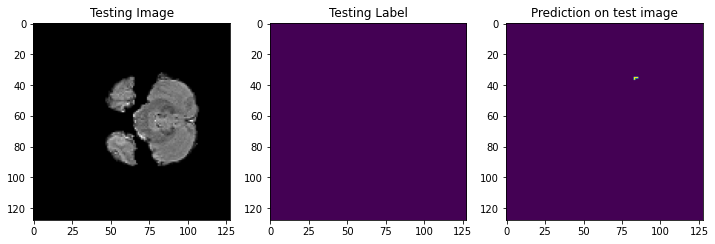

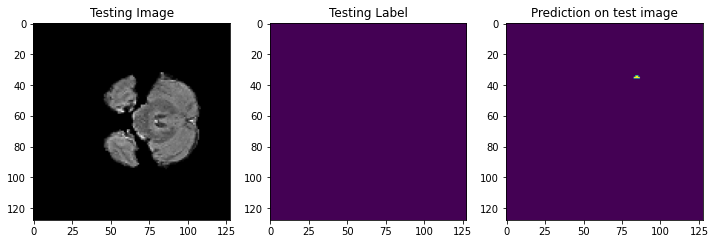

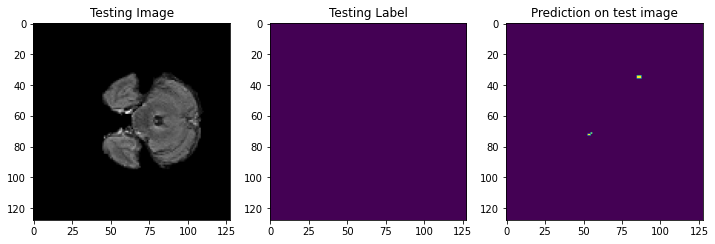

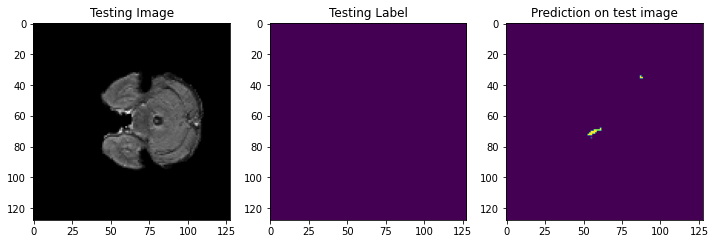

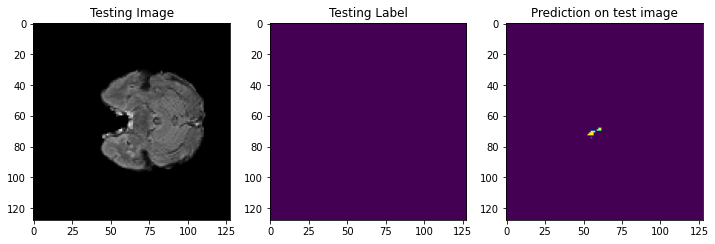

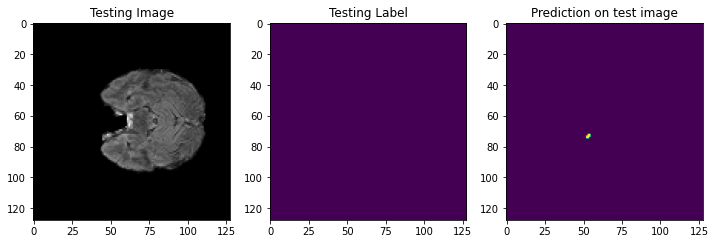

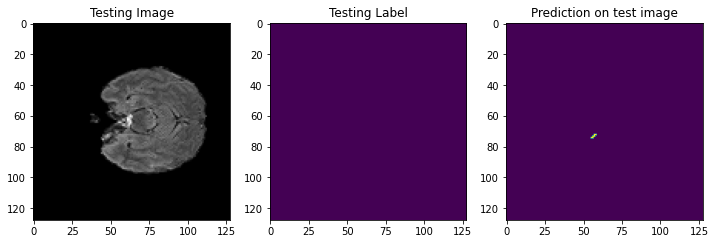

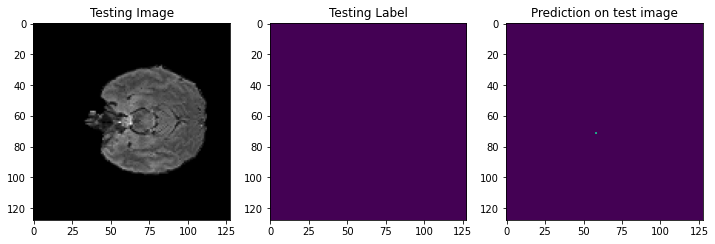

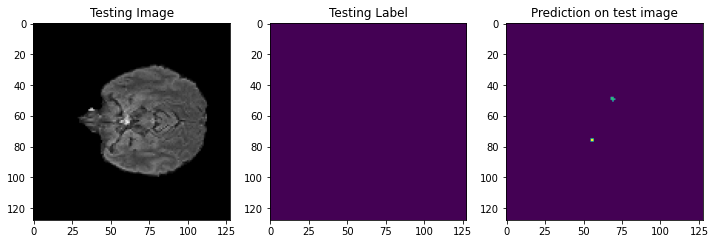

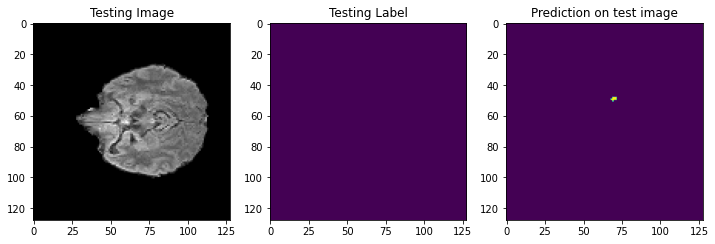

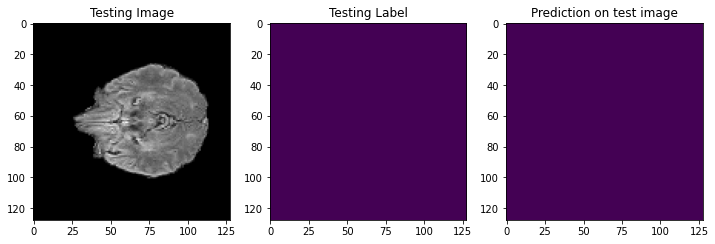

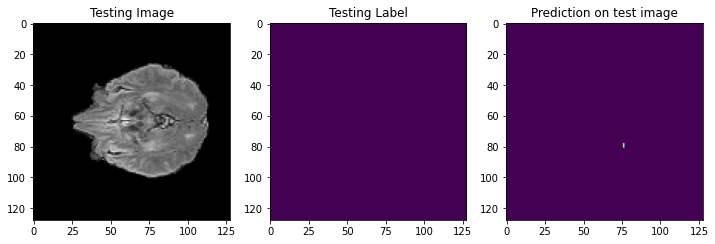

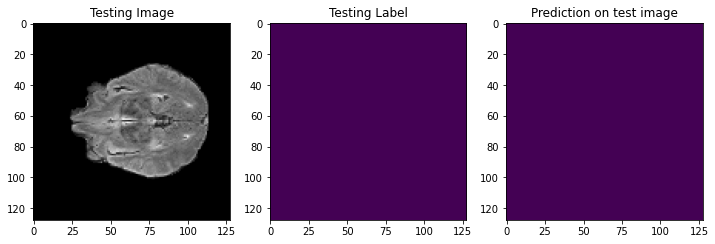

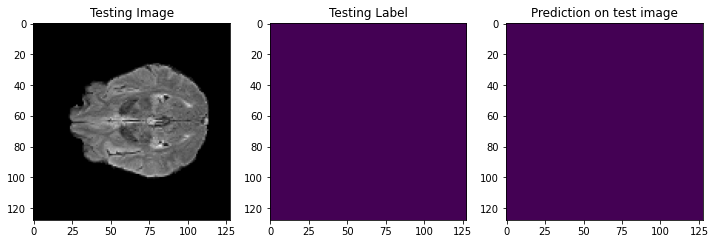

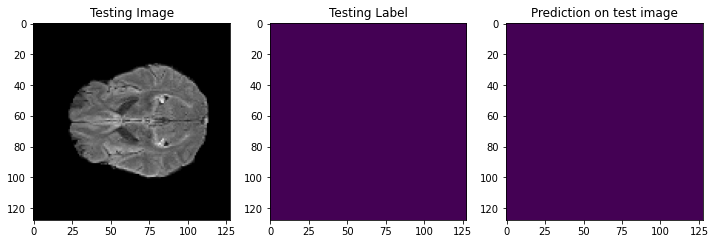

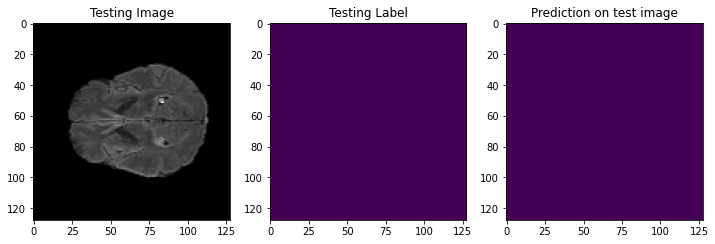

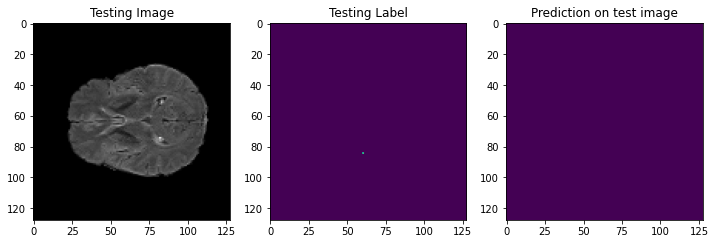

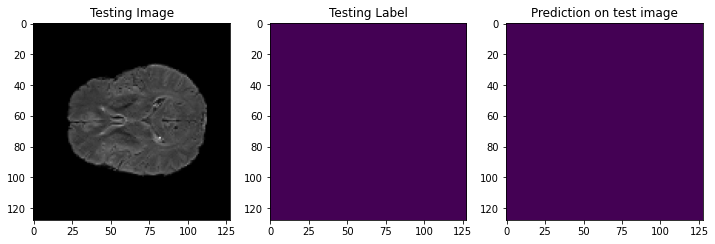

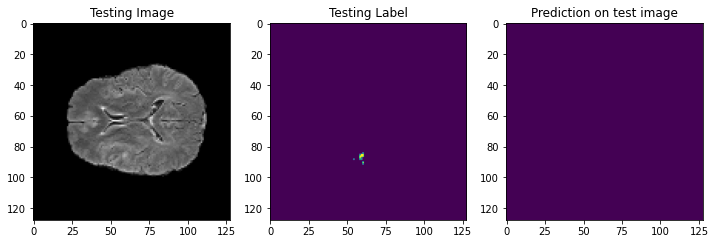

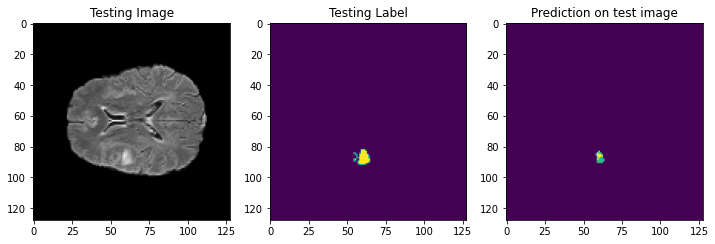

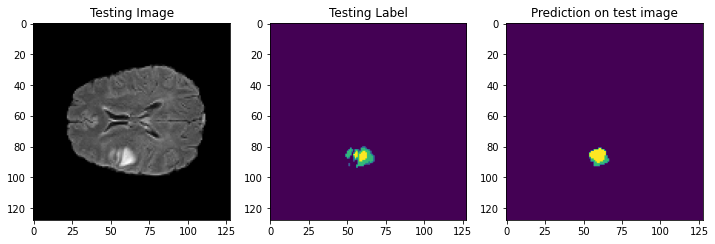

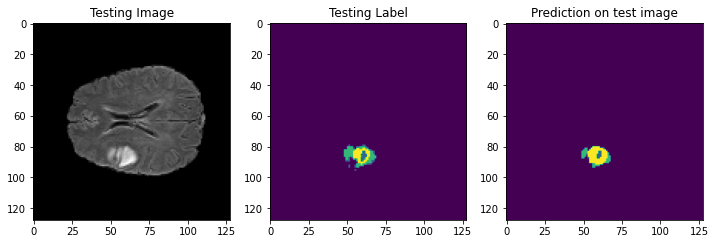

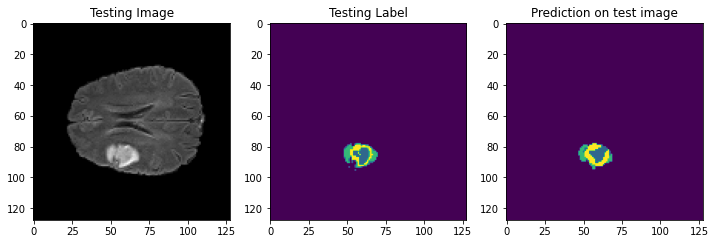

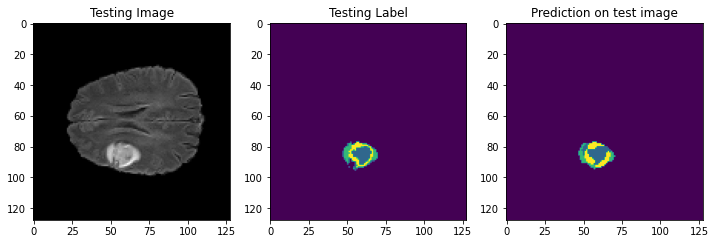

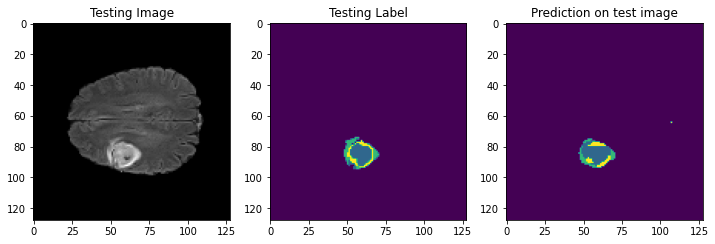

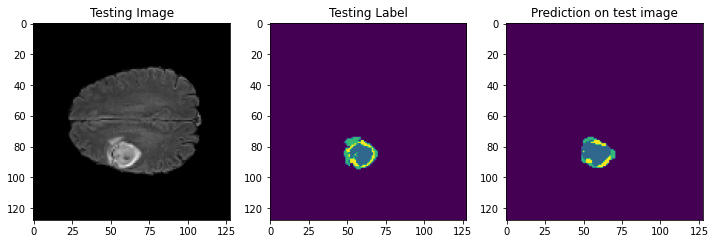

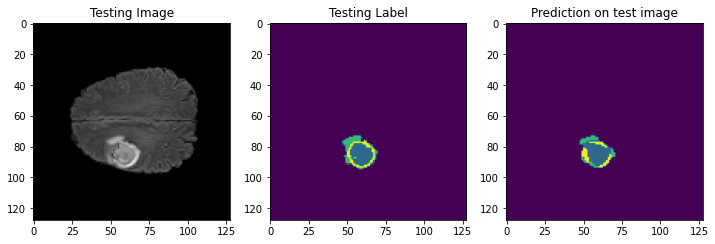

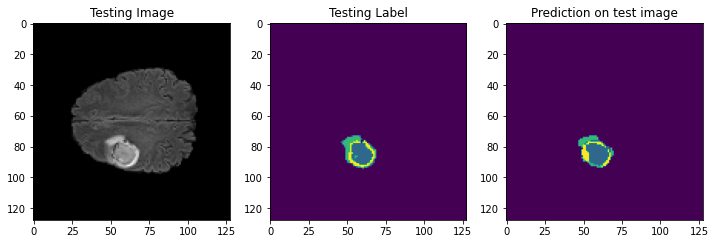

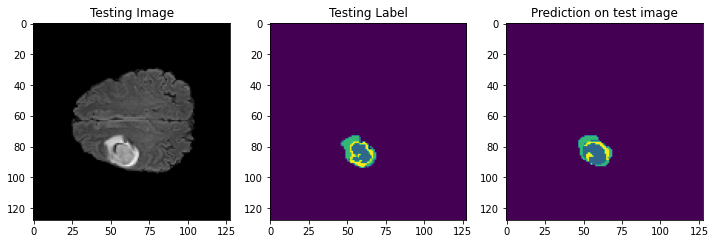

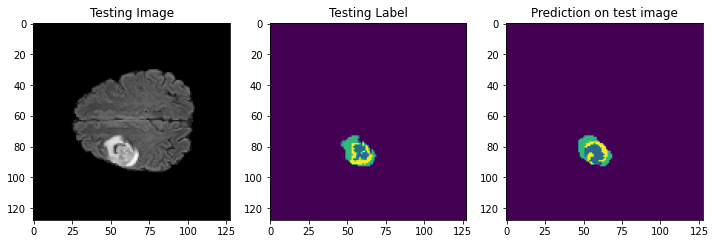

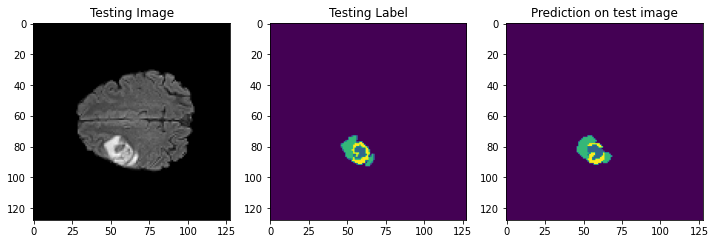

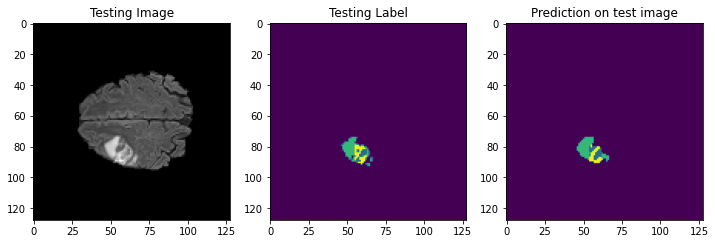

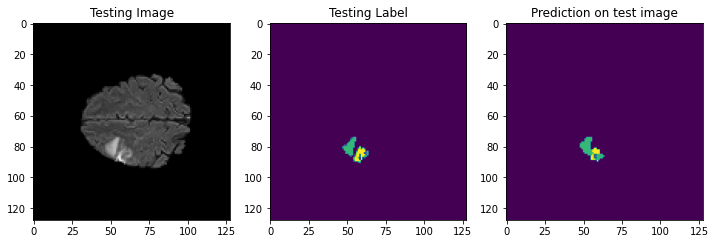

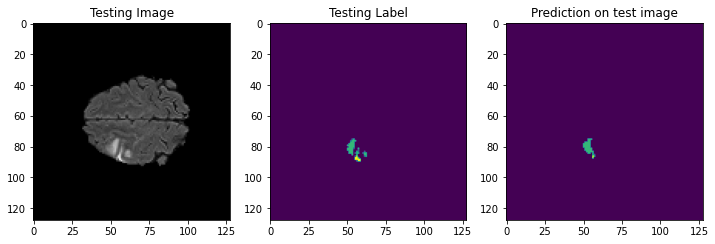

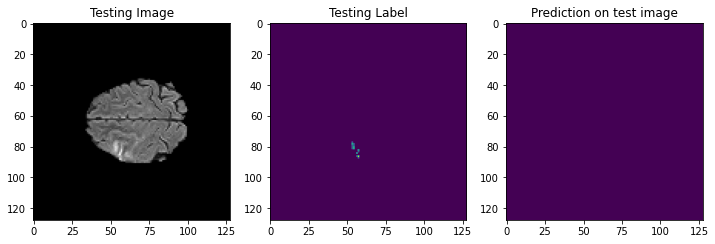

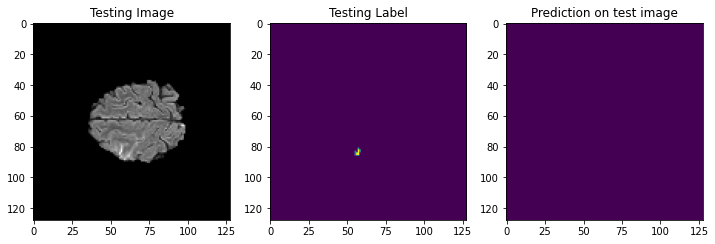

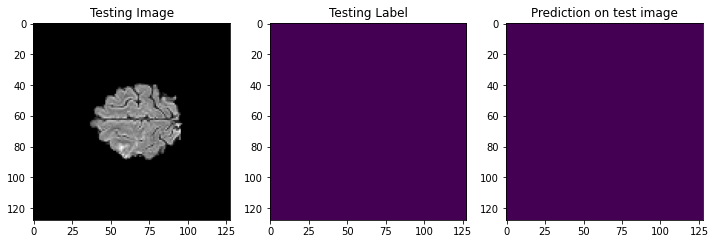

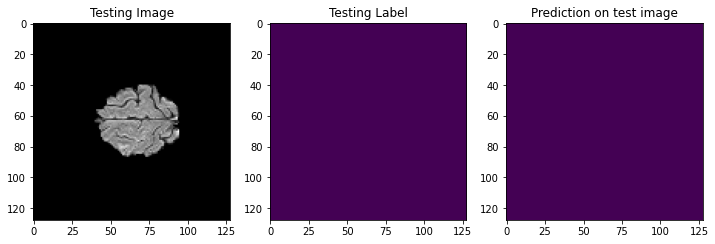

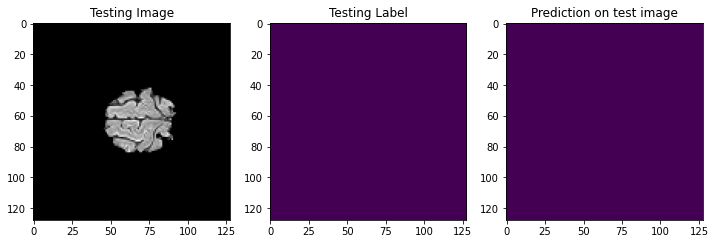

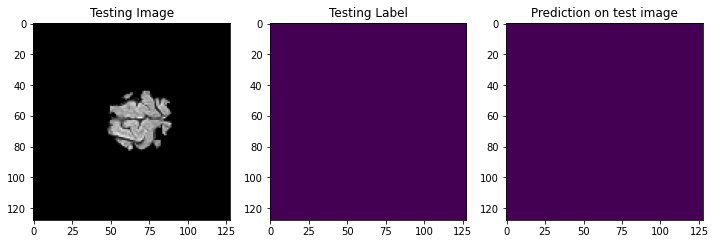

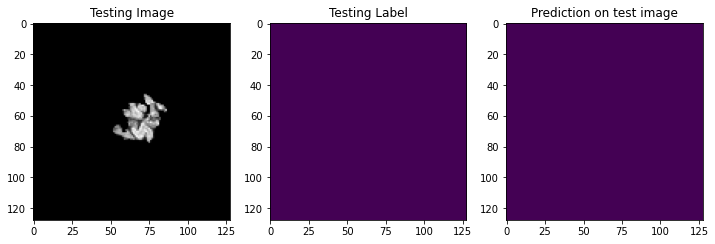

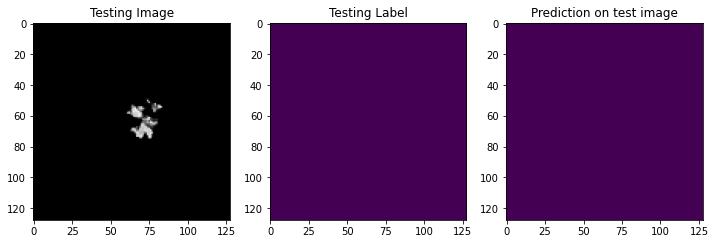

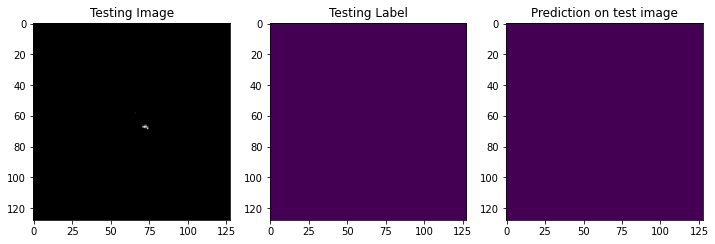

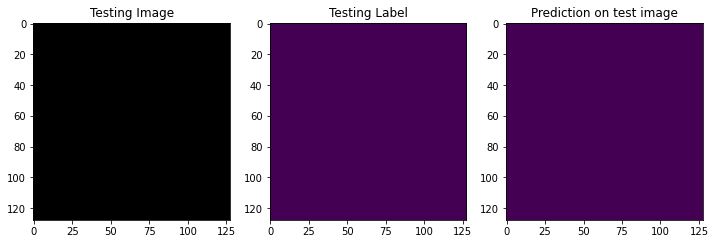

In [39]:
# DataGenerator(ex: test_generator)=>tuple(images,mask)
# images=>[slice,depth,width,height,channels]
# mask=>[slice,depth,width,height,labels]

img_num = 33
test_img = test_generator.__getitem__(img_num)[0]    #tuple(image,mask) -> 0: image
test_mask = test_generator.__getitem__(img_num)[1]   #tuple(image,mask) -> 1: mask
test_mask_argmax=np.argmax(test_mask, axis=4)[0,:,:,:]

test_prediction = model.predict(test_img)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

print("test_prediction_shape: " + str(test_prediction.shape))
print("test_prediction_argmax_shape: " + str(test_prediction_argmax.shape))
print(np.unique(test_prediction_argmax))
print("test_img_shape: " + str(test_img.shape))
print("test_mask_shape: " + str(test_mask.shape))
print("test_mask_argmax: " + str(test_mask_argmax.shape))

n_slice = 15
for n_slice in range(48):
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[0,:,:,n_slice,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(test_mask_argmax[:,:,n_slice])
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(test_prediction_argmax[:,:,n_slice])
    plt.show()

test_prediction_shape: (1, 128, 128, 48, 4)
test_prediction_argmax_shape: (128, 128, 48)
[0 1 2 3]
test_img_shape: (1, 128, 128, 48, 3)
test_mask_shape: (1, 128, 128, 48, 4)
test_mask_argmax: (128, 128, 48)


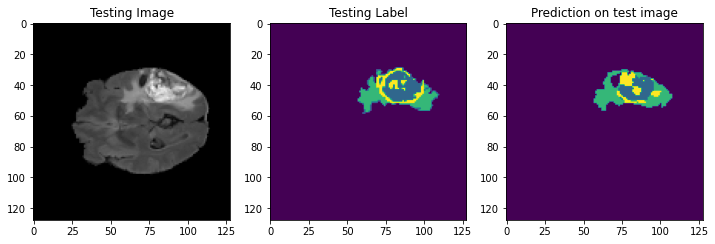

In [41]:
import matplotlib.pyplot as plt

img_num = 19
test_img = test_generator.__getitem__(img_num)[0]    #tuple(image,mask) -> 0: image
test_mask = test_generator.__getitem__(img_num)[1]   #tuple(image,mask) -> 1: mask
test_mask_argmax=np.argmax(test_mask, axis=4)[0,:,:,:]

test_prediction = model.predict(test_img)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

print("test_prediction_shape: " + str(test_prediction.shape))
print("test_prediction_argmax_shape: " + str(test_prediction_argmax.shape))
print(np.unique(test_prediction_argmax))
print("test_img_shape: " + str(test_img.shape))
print("test_mask_shape: " + str(test_mask.shape))
print("test_mask_argmax: " + str(test_mask_argmax.shape))

slice_index = 19

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[0,:,:,slice_index,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,slice_index])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:,slice_index])
plt.show()


test_prediction_shape: (1, 128, 128, 48, 4)
test_prediction_argmax_shape: (128, 128, 48)
Unique values in prediction: [0 1 2 3]
test_img_shape: (1, 128, 128, 48, 3)
test_mask_shape: (1, 128, 128, 48, 4)
test_mask_argmax_shape: (128, 128, 48)


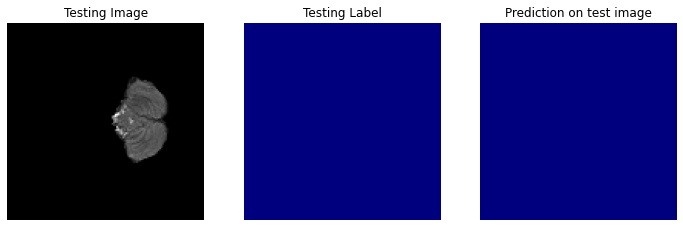

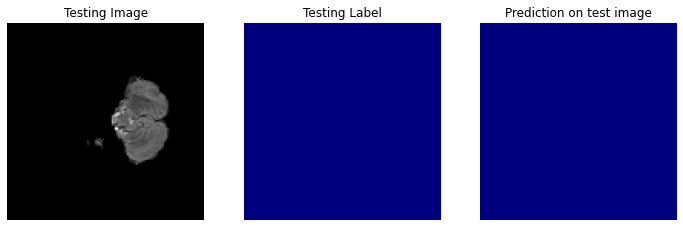

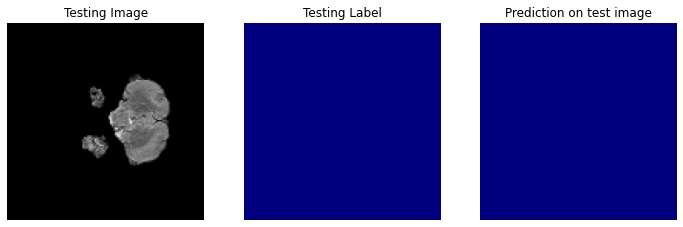

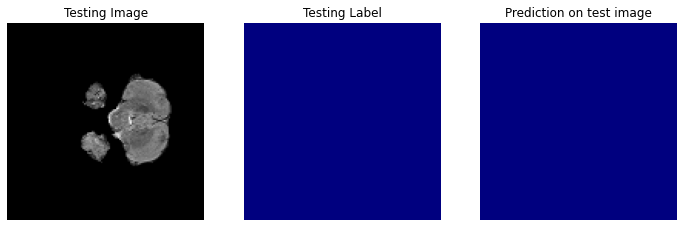

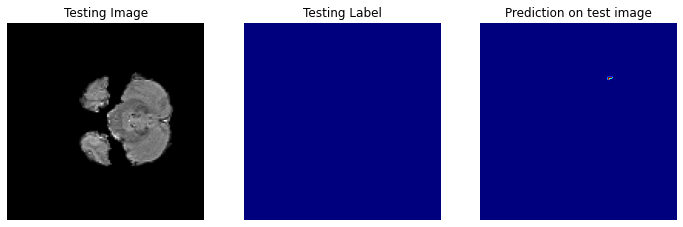

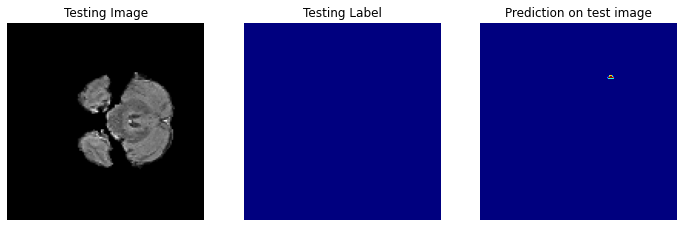

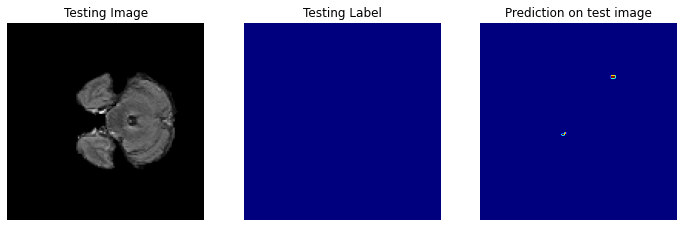

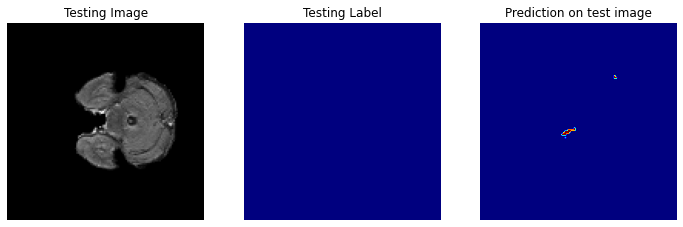

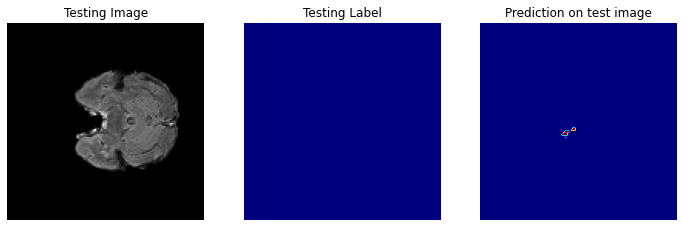

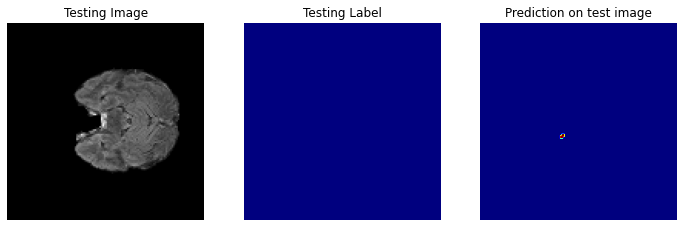

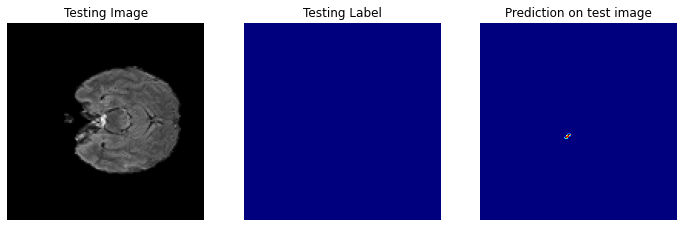

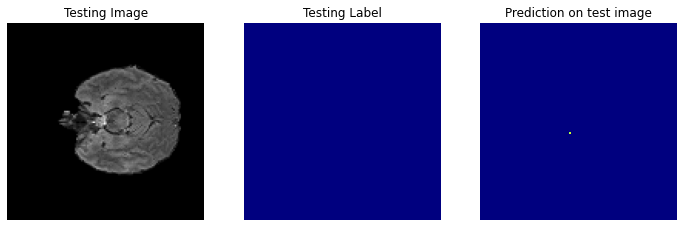

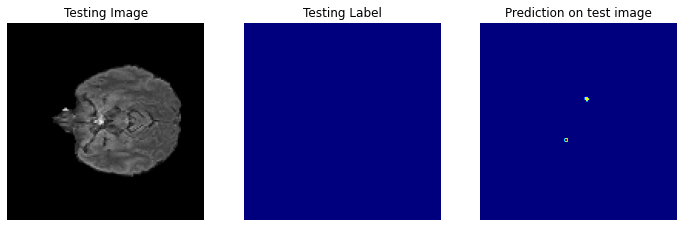

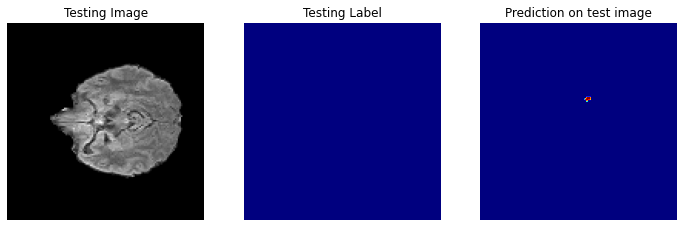

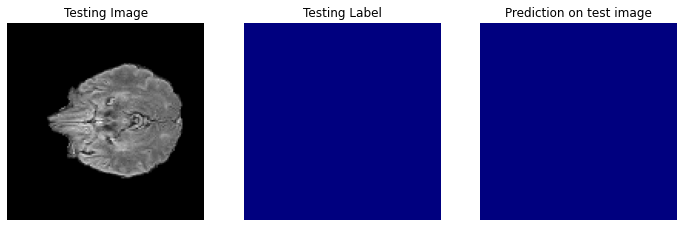

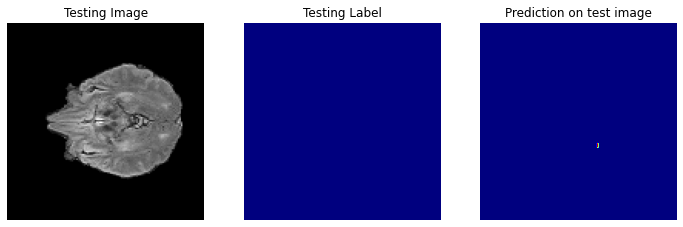

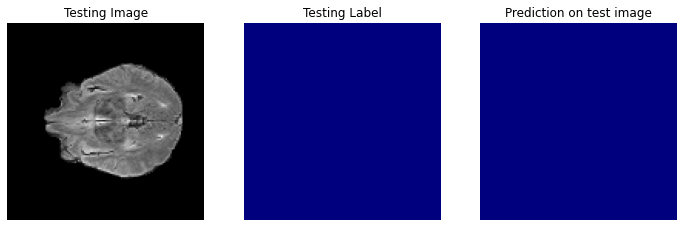

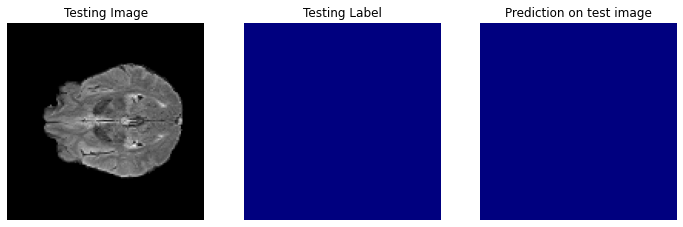

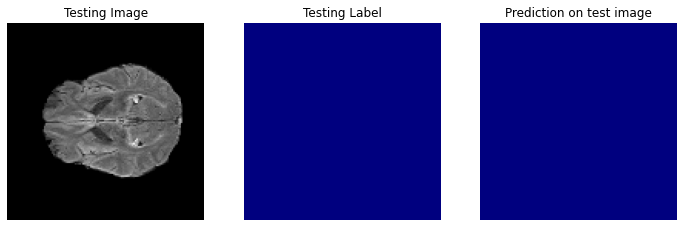

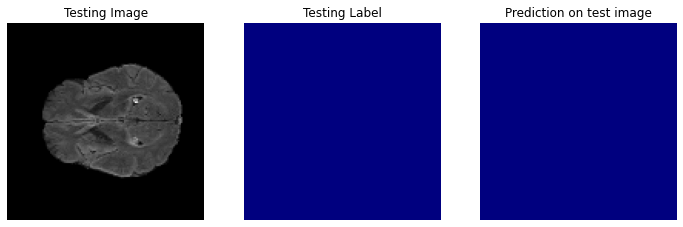

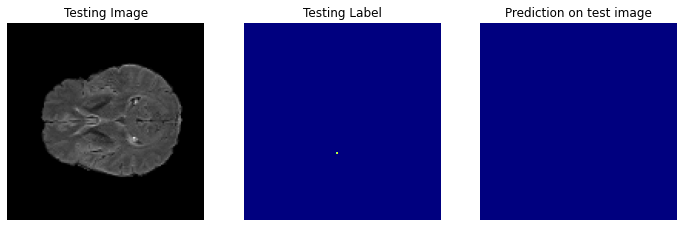

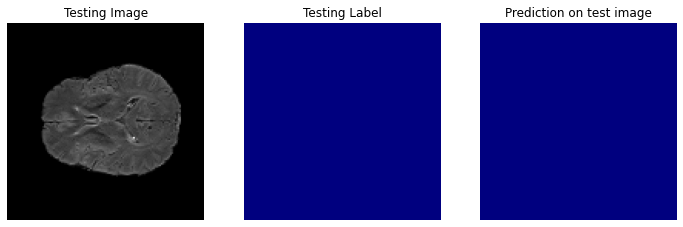

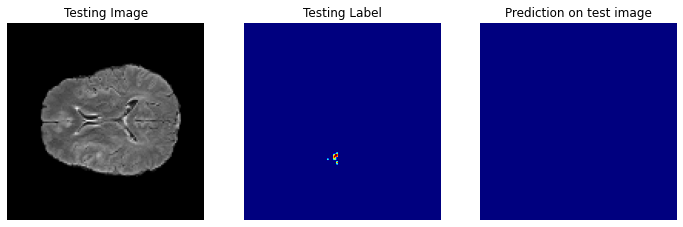

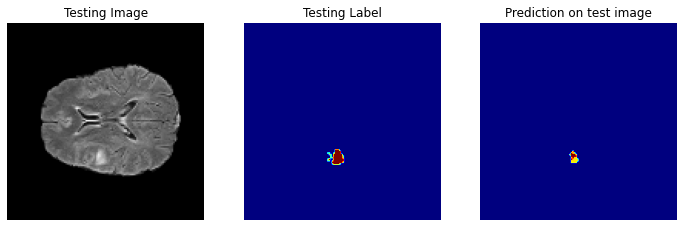

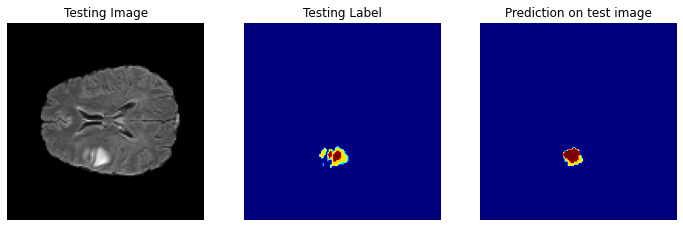

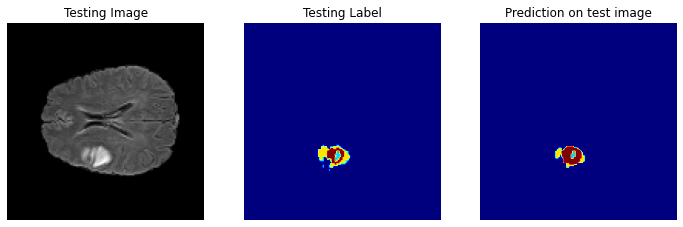

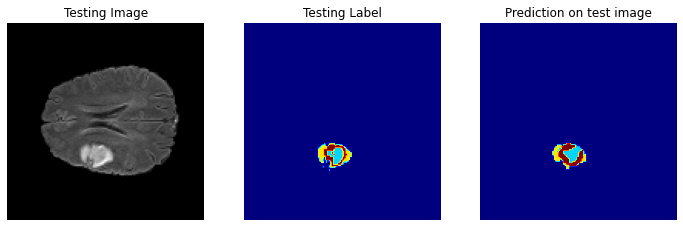

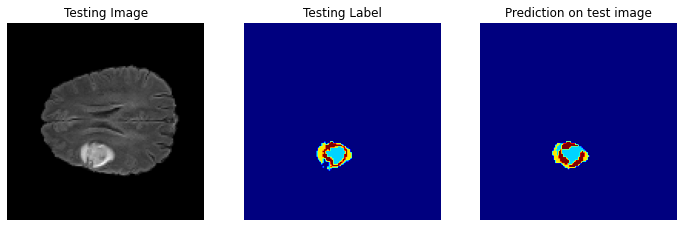

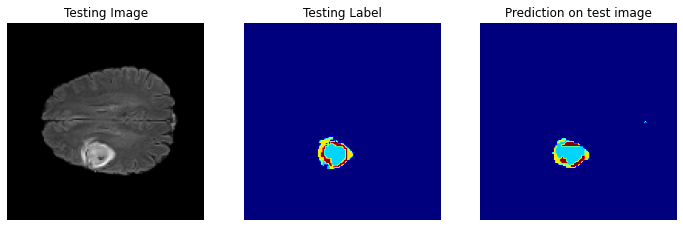

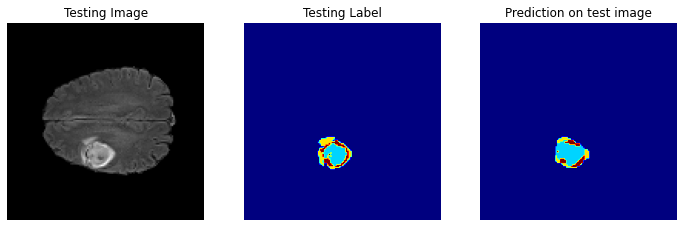

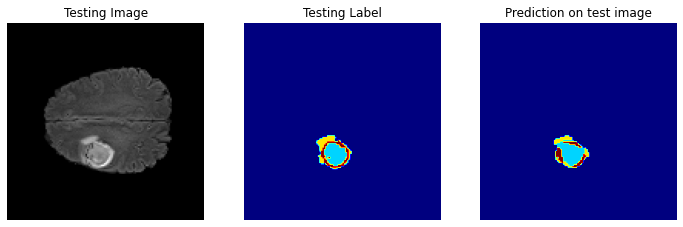

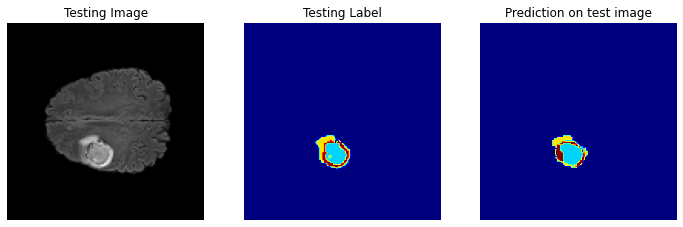

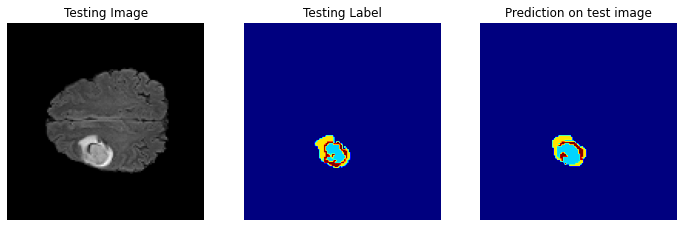

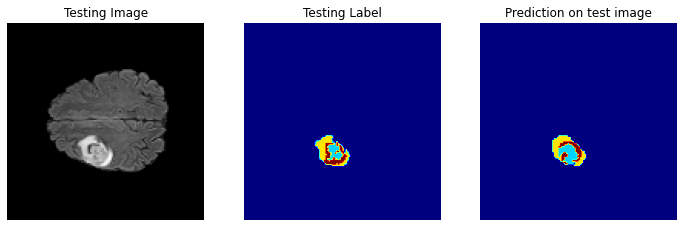

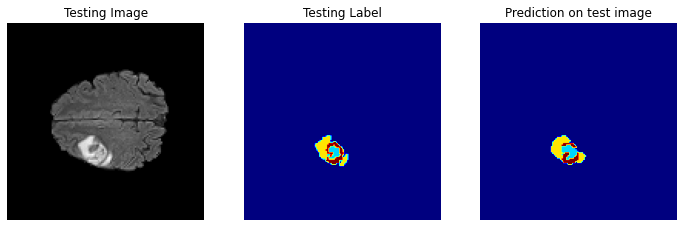

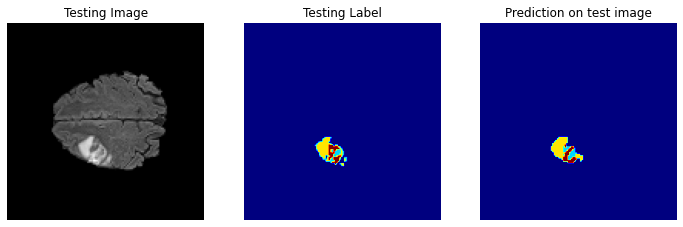

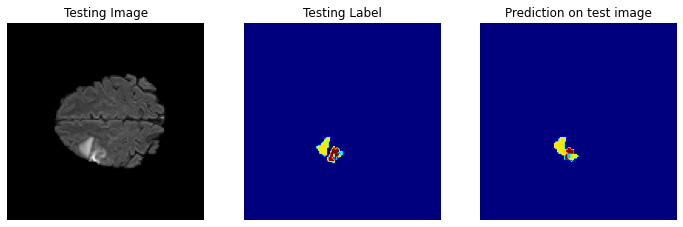

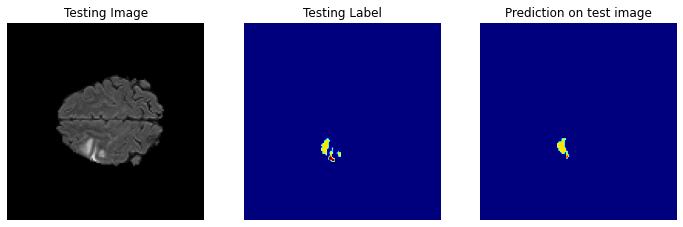

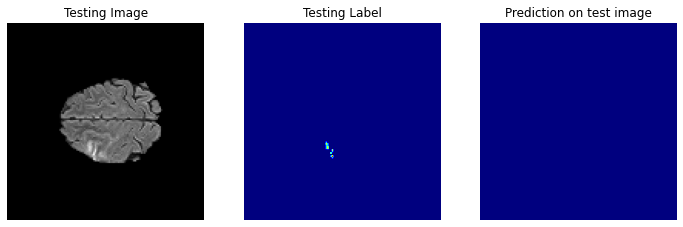

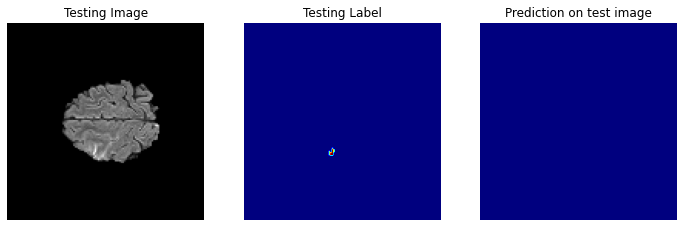

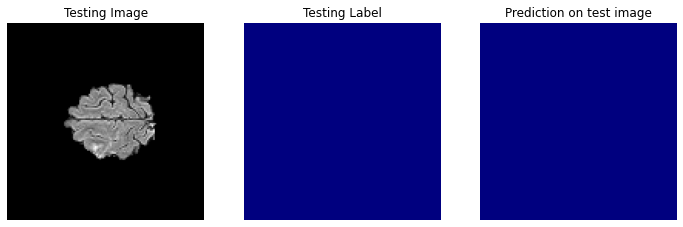

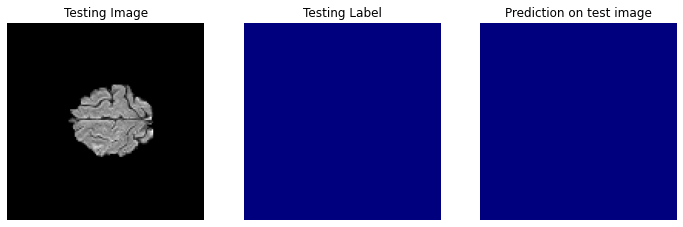

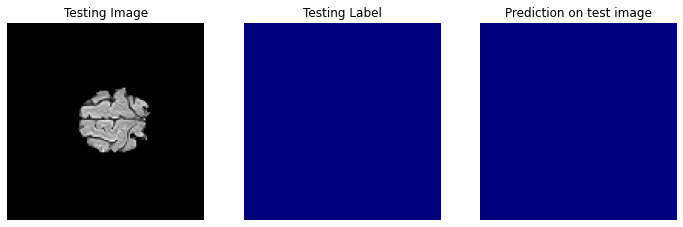

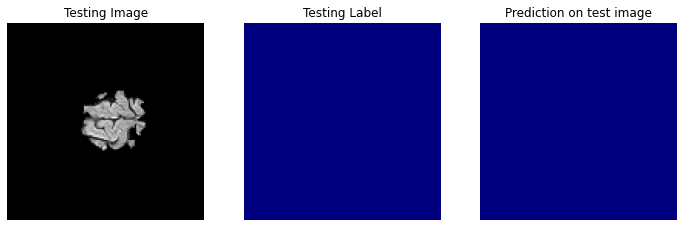

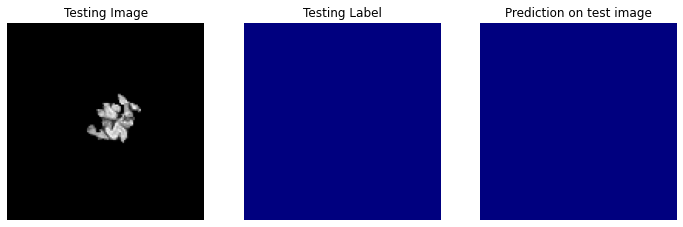

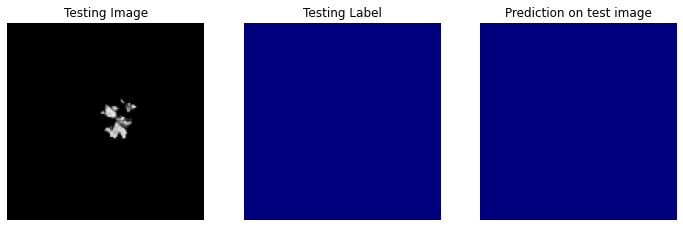

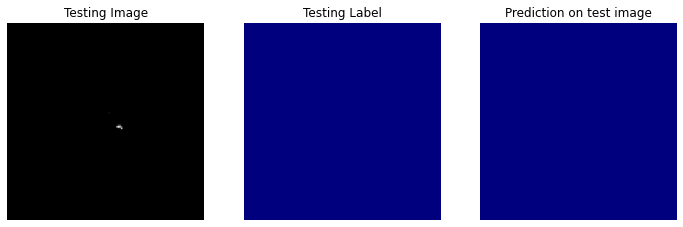

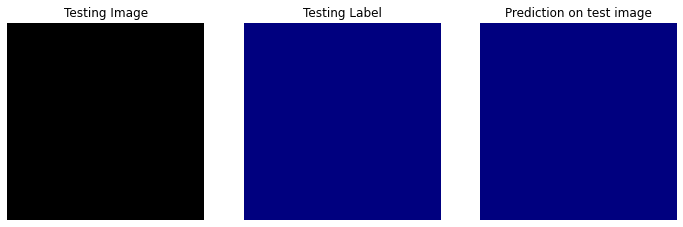

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Load the trained UNet 3+ model
model_path = '/kaggle/working/model_base_unet3d.h5'
model = load_model(model_path, compile=False)

# DataGenerator (e.g., test_generator) => tuple(images, mask)
# images => [slice, depth, width, height, channels]
# mask => [slice, depth, width, height, labels]

# Get a specific image and mask from the test generator
img_num = 33
test_img = test_generator.__getitem__(img_num)[0]    # tuple(image, mask) -> 0: image
test_mask = test_generator.__getitem__(img_num)[1]   # tuple(image, mask) -> 1: mask

# Convert one-hot encoded mask to class labels
test_mask_argmax = np.argmax(test_mask, axis=4)[0, :, :, :]  # Shape: [depth, width, height]

# Predict using the model
test_prediction = model.predict(test_img)  # Shape: [slice, depth, width, height, labels]
test_prediction_argmax = np.argmax(test_prediction, axis=4)[0, :, :, :]  # Shape: [depth, width, height]

# Print shapes and unique values
print("test_prediction_shape: " + str(test_prediction.shape))
print("test_prediction_argmax_shape: " + str(test_prediction_argmax.shape))
print("Unique values in prediction: " + str(np.unique(test_prediction_argmax)))
print("test_img_shape: " + str(test_img.shape))
print("test_mask_shape: " + str(test_mask.shape))
print("test_mask_argmax_shape: " + str(test_mask_argmax.shape))

# Visualize slices
n_slice = 15  # Starting slice index
for n_slice in range(48):  # Loop through all slices (adjust range as needed)
    plt.figure(figsize=(12, 8))
    
    # Plot testing image
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[0, :, :, n_slice, 0], cmap='gray')  # Assuming grayscale image
    plt.axis('off')
    
    # Plot testing label (ground truth)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(test_mask_argmax[:, :, n_slice], cmap='jet')  # Use 'jet' colormap for labels
    plt.axis('off')
    
    # Plot prediction
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(test_prediction_argmax[:, :, n_slice], cmap='jet')  # Use 'jet' colormap for predictions
    plt.axis('off')
    
    plt.show()